/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1: Best Chromosome: [16 13 15], Fitness: -0.043125759810209274
Generation 2: Best Chromosome: [17 13 15], Fitness: -0.06809663772583008
Best Parameters Found: [13 12 11]
Epoch 1/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5148
Epoch 2/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4772 
Epoch 3/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4257 
Epoch 4/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3464 
Epoch 5/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2958 
Epoch 6/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2272 
Epoch 7/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2455 
Epoch 8/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1991 
Epoch 9/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1663 
Epoch 10/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1320 
Epoch 11/11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1248 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Mean Absolute Error: 1036.496679687

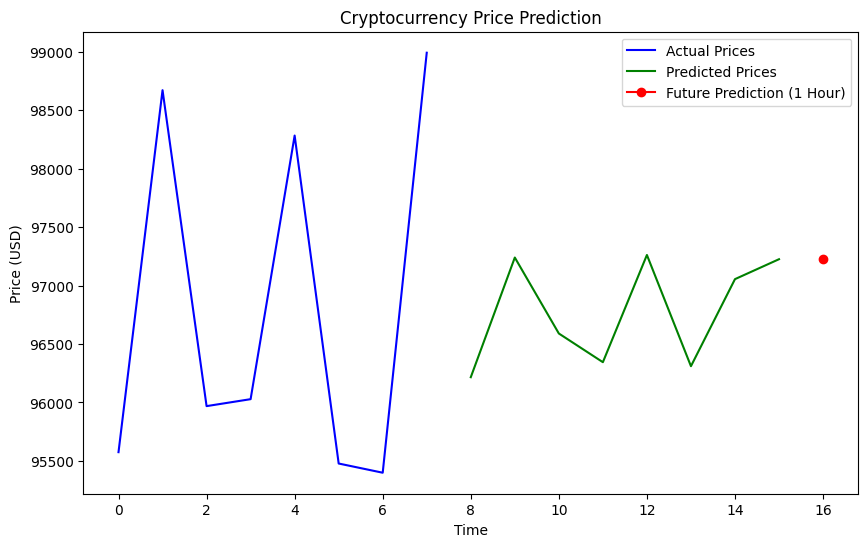

In [6]:
import numpy as np
import pandas as pd
import requests
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Fetch real-time cryptocurrency data
def fetch_crypto_data(symbol='BTC', currency='USD', limit=50):  # Reduced limit to speed up
    url = f"https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={currency}&limit={limit}"
    response = requests.get(url)
    data = response.json()
    if 'Data' in data and 'Data' in data['Data']:
        df = pd.DataFrame(data['Data']['Data'])
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('time', inplace=True)
        return df['close'].values.reshape(-1, 1)
    else:
        raise ValueError("Error fetching cryptocurrency data")

# Preprocess data
def preprocess_data(data, sequence_length=15):  # Reduced sequence length for faster processing
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i])
    return np.array(X), np.array(y), scaler

# Fitness function for GA
def fitness_function(params):
    units, batch_size, epochs = int(params[0]), int(params[1]), int(params[2])
    model = Sequential([LSTM(units, input_shape=(X_train.shape[1], 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    return -loss

# Genetic Algorithm
def genetic_algorithm(X_train, y_train, X_test, y_test, generations=2, population_size=4):
    population = np.random.randint(10, 20, size=(population_size, 3))  # Reduced range for parameters
    for generation in range(generations):
        fitness_scores = [fitness_function(ind) for ind in population]  # Removed multiprocessing
        sorted_indices = np.argsort(fitness_scores)[::-1]
        population = population[sorted_indices]

        print(f"Generation {generation + 1}: Best Chromosome: {population[0]}, Fitness: {fitness_scores[sorted_indices[0]]}")

        # Crossover and Mutation
        new_population = []
        for i in range(population_size // 2):
            parent1, parent2 = population[i], population[(i + 1) % len(population)]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            new_population.extend([child1, child2])

        # Mutation
        for individual in new_population:
            if np.random.rand() < 0.1:  # 10% mutation chance
                mutation_idx = np.random.randint(len(individual))
                individual[mutation_idx] = np.random.randint(10, 20)  # Adjusted mutation range

        population = np.array(new_population[:population_size])
    return population[0]

# Train the LSTM model
def train_lstm_model(X_train, y_train, units, batch_size, epochs):
    model = Sequential([LSTM(units, input_shape=(X_train.shape[1], 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
    return model

# Predict future price for 1 hour
def predict_future(model, X_input):
    prediction = model.predict(X_input)
    return prediction[0][0]

# Plot predictions
def plot_predictions(actual, predicted, future_prediction, scaler):
    actual_prices = scaler.inverse_transform(actual)
    predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
    future_price = scaler.inverse_transform(future_prediction.reshape(-1, 1))

    plt.figure(figsize=(10,6))
    plt.plot(actual_prices, color='blue', label='Actual Prices')
    plt.plot(np.arange(len(actual), len(actual) + len(predicted)), predicted_prices, color='green', label='Predicted Prices')
    plt.plot(len(actual) + len(predicted), future_price, color='red', marker='o', label='Future Prediction (1 Hour)')

    plt.title('Cryptocurrency Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

# Main execution
try:
    # Fetch data
    crypto_data = fetch_crypto_data()

    # Preprocess data
    X, y, scaler = preprocess_data(crypto_data, sequence_length=15)  # Sequence length for input features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Run Genetic Algorithm
    best_params = genetic_algorithm(X_train, y_train, X_test, y_test, generations=2, population_size=4)
    print(f"Best Parameters Found: {best_params}")

    # Train the model with the best parameters
    best_units, best_batch_size, best_epochs = map(int, best_params)
    model = train_lstm_model(X_train, y_train, best_units, best_batch_size, best_epochs)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Predict the next 1 hour
    future_prediction = predict_future(model, X_test[-1].reshape(1, X_test.shape[1], 1))  # Predict for the last test input

    # Calculate MAE and RMSE
    mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), scaler.inverse_transform(predictions.reshape(-1, 1)))
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), scaler.inverse_transform(predictions.reshape(-1, 1))))

    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Predicted Future Price (1 Hour): {scaler.inverse_transform([[future_prediction]])[0][0]} USD")

    # Plot predictions and future forecast
    plot_predictions(y_test, predictions, future_prediction, scaler)

except Exception as e:
    print(f"Error: {e}")

